In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import os 
from glob import glob
import matplotlib as mpl 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import permutation_test
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from methods import * 

%load_ext autoreload
%autoreload 2

In [2]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
)

np.random.seed(42)
train_inds = np.random.choice(dataset.shape[0], 10000, replace=False)
df_train = dataset.iloc[train_inds]

X_train = df_train.drop(columns='default')
y_train = df_train['default']

In [4]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
df_test = dataset[~dataset.index.isin(train_inds)]
df1 = df_test[(df_test.EDUCATION <= 1) & (df_test.default == 0)]
df2 = df_test[(df_test.EDUCATION >= 3) & (df_test.default == 0)]
X1 = df1.drop(columns='default')
X2 = df2.drop(columns='default')
X1.shape, X2.shape

((5755, 23), (2714, 23))

In [7]:
y1 = clf.predict(X1)
y2 = clf.predict(X2)

z1 = y1 + np.mean(y2) - np.mean(y1)
z2 = y2
print(np.mean(y1), np.mean(y2), np.mean(z1), np.mean(z2))

0.03770634231103388 0.07184966838614591 0.07184966838614593 0.07184966838614591


In [ ]:
alphas = np.linspace(0.005, 0.1, 20)
iters = 20 

betting_tau, _ = betting_experiment(y1, y2, alphas, iters) # Alternative 
_, betting_fdr = betting_experiment(z1, z2, alphas, iters) # Null 

permb_250_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=250, bonferroni=True)
_, permb_250_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=250, bonferroni=True)

permb_500_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=500, bonferroni=True)
_, permb_500_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=500, bonferroni=True)

permb_1000_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=1000, bonferroni=True)
_, permb_1000_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=1000, bonferroni=True)


save_results('betting_loan_tau', betting_tau)
save_results('betting_loan_fdr', betting_fdr)
save_results('permb_250_loan_tau', permb_250_tau)
save_results('permb_250_loan_fdr', permb_250_fdr)
save_results('permb_500_loan_tau', permb_500_tau)
save_results('permb_500_loan_fdr', permb_500_fdr)
save_results('permb_1000_loan_tau', permb_1000_tau)
save_results('permb_1000_loan_fdr', permb_1000_fdr)

In [19]:
perm_250_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=250, bonferroni=False)
_, perm_250_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=250, bonferroni=False)

perm_500_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=500, bonferroni=False)
_, perm_500_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=500, bonferroni=False)

perm_1000_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=1000, bonferroni=False)
_, perm_1000_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=1000, bonferroni=False)

save_results('perm_250_loan_tau', perm_250_tau)
save_results('perm_250_loan_fdr', perm_250_fdr)
save_results('perm_500_loan_tau', perm_500_tau)
save_results('perm_500_loan_fdr', perm_500_fdr)
save_results('perm_1000_loan_tau', perm_1000_tau)
save_results('perm_1000_loan_fdr', perm_1000_fdr)


In [38]:
len(betting_tau)

190

Text(0, 0.5, 'FPR under $H_0$')

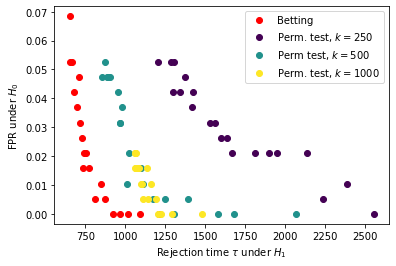

In [37]:
betting_tau = load_results('betting_loan_tau')
betting_fdr = load_results('betting_loan_fdr')
permb_250_tau = load_results('permb_250_loan_tau')
permb_250_fdr = load_results('permb_250_loan_fdr')
permb_500_tau = load_results('permb_500_loan_tau')
permb_500_fdr = load_results('permb_500_loan_fdr')
permb_1000_tau = load_results('permb_1000_loan_tau')
permb_1000_fdr = load_results('permb_1000_loan_fdr')


cm = plt.get_cmap('viridis') 
cmap = [cm(i) for i in np.linspace(0,1,3)]


plt.plot(np.mean(betting_tau, axis=0), np.mean(betting_fdr, axis=0), 'o', c='red', label='Betting')
plt.plot(np.mean(permb_250_tau, axis=0), np.mean(permb_250_fdr, axis=0), 'o', c=cmap[0], label='Perm. test, $k=250$')
plt.plot(np.mean(permb_500_tau, axis=0), np.mean(permb_500_fdr, axis=0), 'o', c=cmap[1], label='Perm test, $k=500$')
plt.plot(np.mean(permb_1000_tau, axis=0), np.mean(permb_1000_fdr, axis=0), 'o', c=cmap[2], label='Perm. test, $k=1000$')

plt.legend()
plt.xlabel('Rejection time $\\tau$ under $H_1$')
plt.ylabel('FPR under $H_0$')
    

Text(0, 0.5, 'FPR under $H_0$')

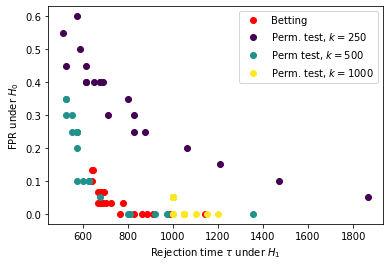

In [20]:
cm = plt.get_cmap('viridis') 
cmap = [cm(i) for i in np.linspace(0,1,3)]


plt.plot(np.mean(betting_tau, axis=0), np.mean(betting_fdr, axis=0), 'o', c='red', label='Betting')
plt.plot(np.mean(perm_250_tau, axis=0), np.mean(perm_250_fdr, axis=0), 'o', c=cmap[0], label='Perm. test, $k=250$')
plt.plot(np.mean(perm_500_tau, axis=0), np.mean(perm_500_fdr, axis=0), 'o', c=cmap[1], label='Perm test, $k=500$')
plt.plot(np.mean(perm_1000_tau, axis=0), np.mean(perm_1000_fdr, axis=0), 'o', c=cmap[2], label='Perm. test, $k=1000$')

plt.legend()
plt.xlabel('Rejection time $\\tau$ under $H_1$')
plt.ylabel('FPR under $H_0$')
    